In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import mean_squared_error, r2_score
import warnings
warnings.filterwarnings('ignore')


Dataset Overview:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 244 entries, 0 to 243
Data columns (total 7 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   total_bill  244 non-null    float64
 1   tip         244 non-null    float64
 2   sex         244 non-null    object 
 3   smoker      244 non-null    object 
 4   day         244 non-null    object 
 5   time        244 non-null    object 
 6   size        244 non-null    int64  
dtypes: float64(2), int64(1), object(4)
memory usage: 13.5+ KB
None

Basic Statistics:
       total_bill         tip        size
count  244.000000  244.000000  244.000000
mean    19.785943    2.998279    2.569672
std      8.902412    1.383638    0.951100
min      3.070000    1.000000    1.000000
25%     13.347500    2.000000    2.000000
50%     17.795000    2.900000    2.000000
75%     24.127500    3.562500    3.000000
max     50.810000   10.000000    6.000000


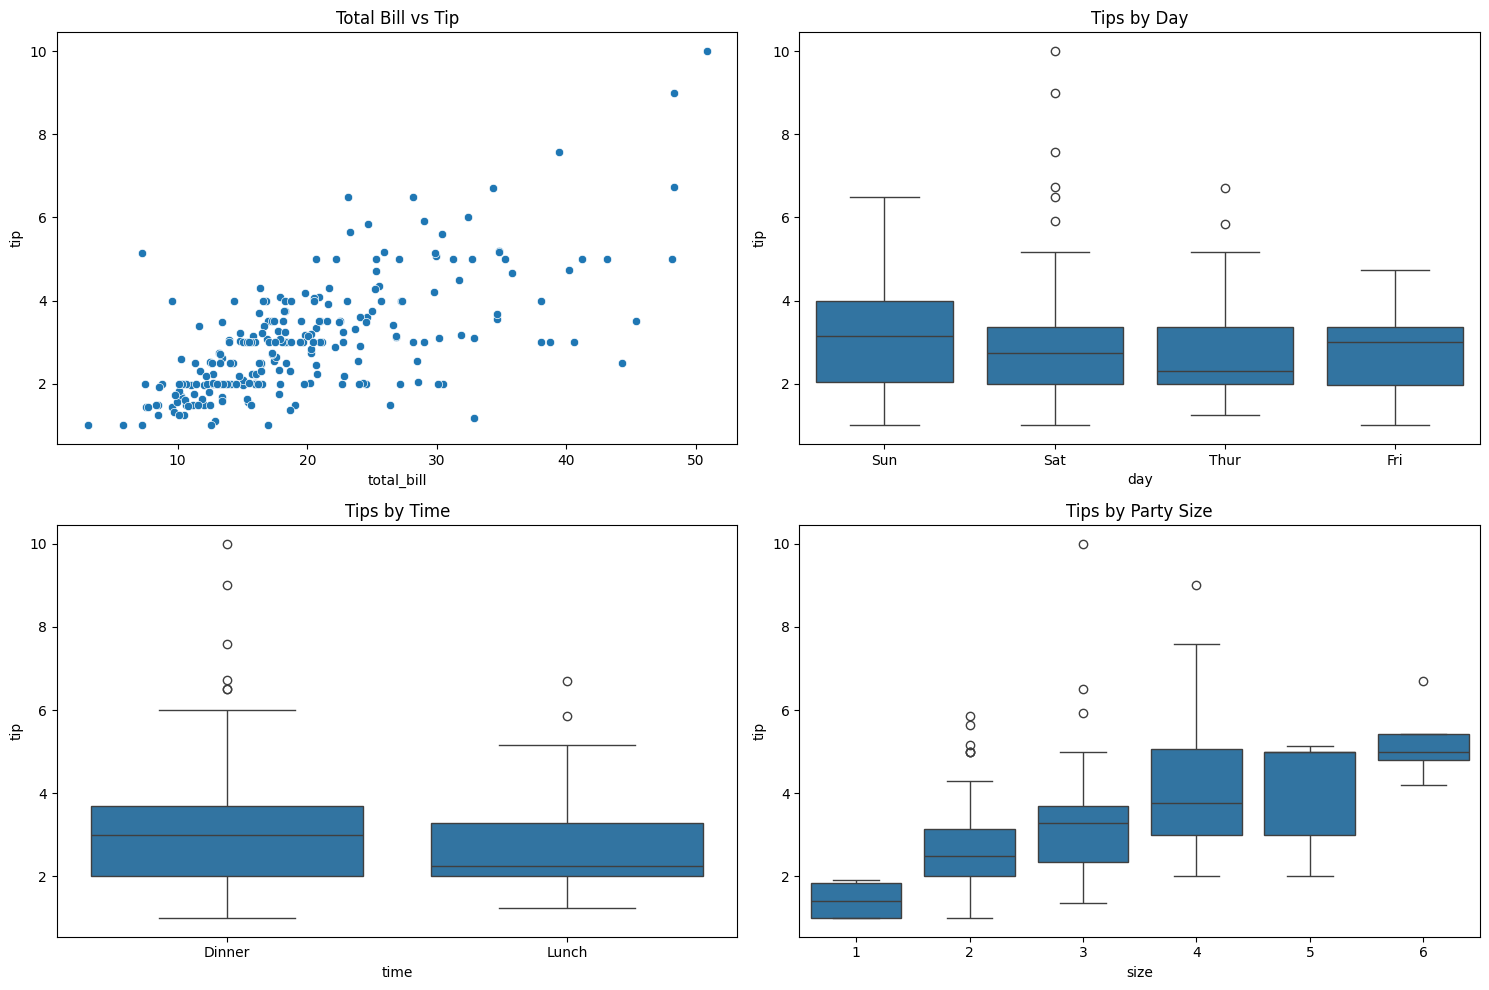

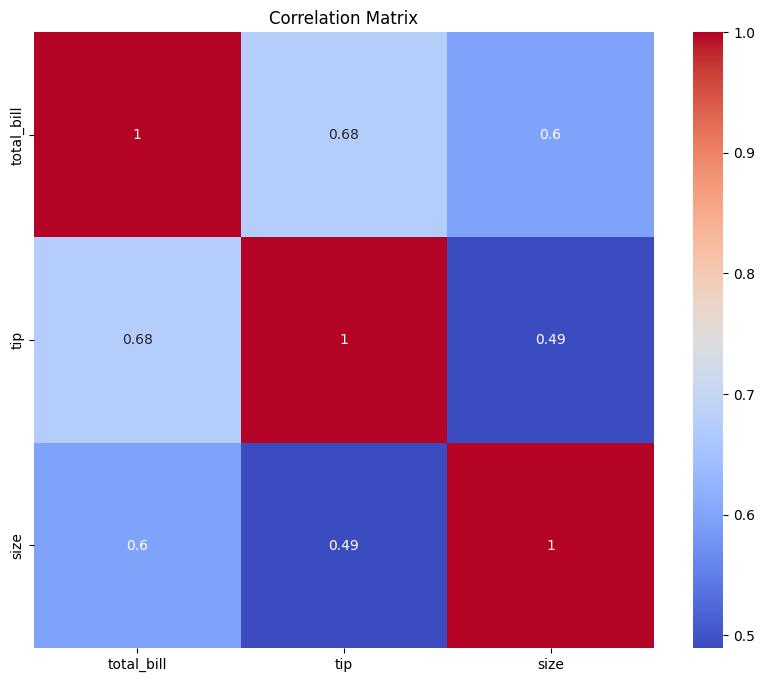

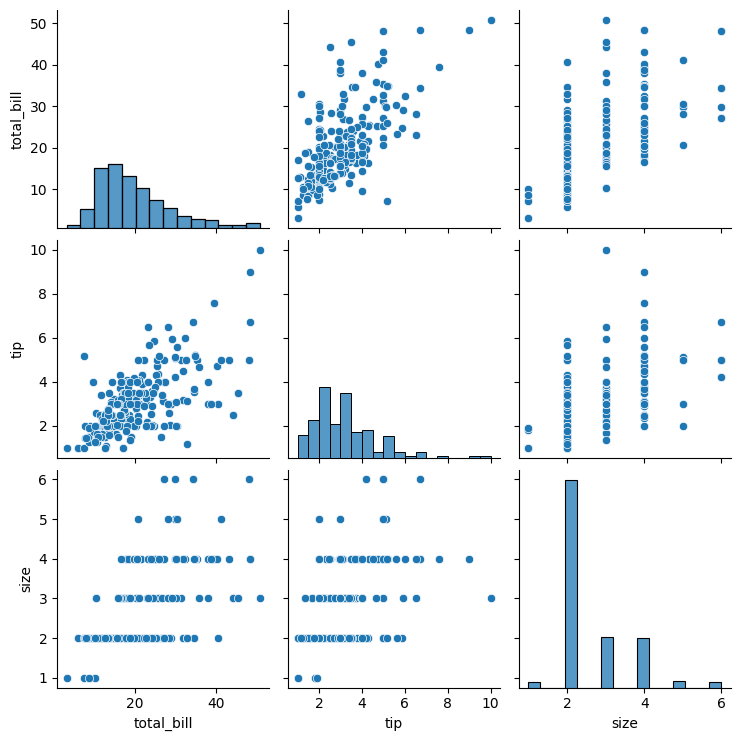

In [7]:
# Load the data
data = pd.read_csv('/content/tips (data for regression problem).csv')

# 1. Data Exploration and Visualization
print("Dataset Overview:")
print(data.info())
print("\nBasic Statistics:")
print(data.describe())

# Create visualizations
plt.figure(figsize=(15, 10))

# Scatter plot: total_bill vs tip
plt.subplot(2, 2, 1)
sns.scatterplot(data=data, x='total_bill', y='tip')
plt.title('Total Bill vs Tip')

# Box plot: day vs tip
plt.subplot(2, 2, 2)
sns.boxplot(data=data, x='day', y='tip')
plt.title('Tips by Day')

# Box plot: time vs tip
plt.subplot(2, 2, 3)
sns.boxplot(data=data, x='time', y='tip')
plt.title('Tips by Time')

# Box plot: size vs tip
plt.subplot(2, 2, 4)
sns.boxplot(data=data, x='size', y='tip')
plt.title('Tips by Party Size')
plt.tight_layout()
plt.show()

# Correlation Matrix
plt.figure(figsize=(10, 8))
numeric_cols = data.select_dtypes(include=['float64', 'int64']).columns
correlation_matrix = data[numeric_cols].corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')
plt.title('Correlation Matrix')
plt.show()

# Pair Plot
sns.pairplot(data[['total_bill', 'tip', 'size']])
plt.show()


In [8]:
# Prepare data for modeling
X = data.drop('tip', axis=1)
y = data['tip']

# Split numeric and categorical columns
numeric_features = X.select_dtypes(include=['float64', 'int64']).columns
categorical_features = X.select_dtypes(include=['object']).columns

# Create preprocessing steps
numeric_transformer = StandardScaler()
categorical_transformer = OneHotEncoder(drop='first', sparse_output=False)

# Combine preprocessing steps
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ])

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Define models
models = {
    'Linear Regression': LinearRegression(),
    'Ridge Regression': Ridge(alpha=1.0),
    'Lasso Regression': Lasso(alpha=1.0),
    'Decision Tree': DecisionTreeRegressor(random_state=42),
    'Random Forest': RandomForestRegressor(random_state=42),
    'SVR': SVR(kernel='rbf'),
    'KNN': KNeighborsRegressor(n_neighbors=5)
}



Model Comparison:
               Model       MSE  R2 Score  CV R2 Mean  CV R2 Std
0  Linear Regression  0.703357  0.437302    0.421493   0.135312
1   Ridge Regression  0.700651  0.439466    0.423053   0.133408
2   Lasso Regression  1.448668 -0.158961   -0.023081   0.016685
3      Decision Tree  1.255194 -0.004178    0.104297   0.164312
4      Random Forest  0.918199  0.265424    0.401490   0.121233
5                SVR  0.709525  0.432367    0.404875   0.130168
6                KNN  0.814505  0.348381    0.337771   0.083150


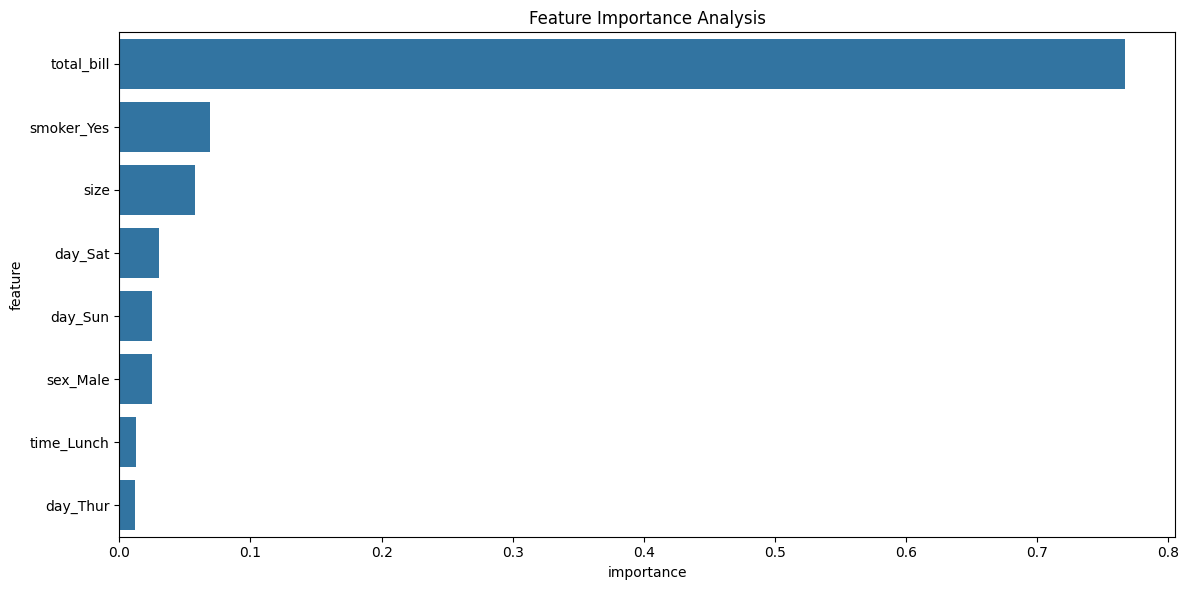

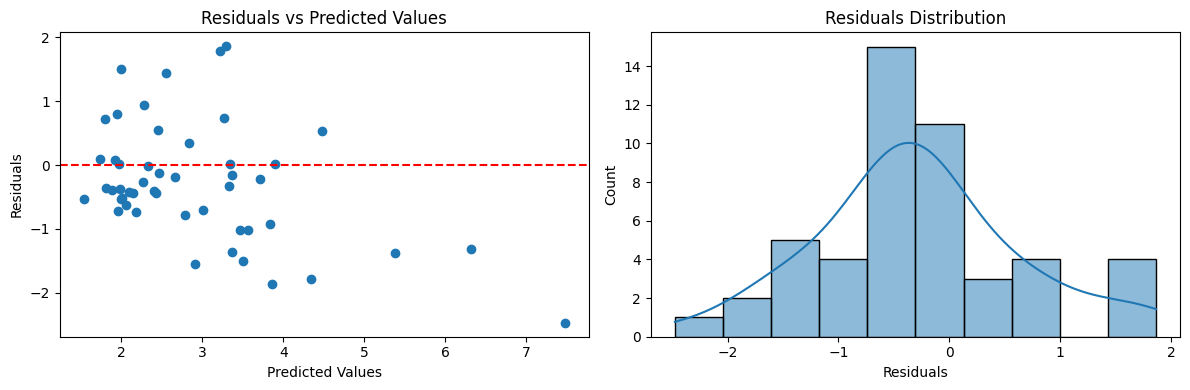


Key Findings and Insights:
1. Model Performance:
   - Best performing model: Ridge Regression
   - R2 Score: 0.439

2. Important Factors Affecting Tips:
   - Top 3 most influential features:
     * total_bill: 0.767
     * smoker_Yes: 0.069
     * size: 0.058

3. Recommendations for Management:
   - Focus on total bill amount as it shows strong correlation with tips
   - Consider party size in service allocation
   - Monitor service quality during peak times
   - Use the predictive model for staff training and service optimization


In [9]:
# Train and evaluate models
results = []

for name, model in models.items():
    # Create pipeline
    pipeline = Pipeline([
        ('preprocessor', preprocessor),
        ('regressor', model)
    ])

    # Fit the pipeline
    pipeline.fit(X_train, y_train)

    # Make predictions
    y_pred = pipeline.predict(X_test)

    # Calculate metrics
    mse = mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)

    # Cross-validation score
    cv_scores = cross_val_score(pipeline, X, y, cv=5, scoring='r2')

    results.append({
        'Model': name,
        'MSE': mse,
        'R2 Score': r2,
        'CV R2 Mean': cv_scores.mean(),
        'CV R2 Std': cv_scores.std()
    })

# Create results DataFrame
results_df = pd.DataFrame(results)
print("\nModel Comparison:")
print(results_df)

# Feature importance analysis using Random Forest
rf_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('regressor', RandomForestRegressor(random_state=42))
])

rf_pipeline.fit(X_train, y_train)
feature_importance = rf_pipeline.named_steps['regressor'].feature_importances_

# Get feature names after preprocessing
feature_names = (numeric_features.tolist() +
                [f"{feat}_{val}" for feat, vals in
                 zip(categorical_features,
                     categorical_transformer.fit(X[categorical_features]).categories_)
                 for val in vals[1:]])

# Plot feature importance
plt.figure(figsize=(12, 6))
importance_df = pd.DataFrame({'feature': feature_names, 'importance': feature_importance})
importance_df = importance_df.sort_values('importance', ascending=False)
sns.barplot(data=importance_df, x='importance', y='feature')
plt.title('Feature Importance Analysis')
plt.tight_layout()
plt.show()

# Residual analysis for the best performing model
best_model = rf_pipeline  # Using Random Forest as an example
y_pred = best_model.predict(X_test)
residuals = y_test - y_pred

plt.figure(figsize=(12, 4))

# Residuals vs Predicted Values
plt.subplot(1, 2, 1)
plt.scatter(y_pred, residuals)
plt.axhline(y=0, color='r', linestyle='--')
plt.xlabel('Predicted Values')
plt.ylabel('Residuals')
plt.title('Residuals vs Predicted Values')

# Residuals Distribution
plt.subplot(1, 2, 2)
sns.histplot(residuals, kde=True)
plt.xlabel('Residuals')
plt.title('Residuals Distribution')
plt.tight_layout()
plt.show()

# Print key findings and insights
print("\nKey Findings and Insights:")
print("1. Model Performance:")
best_model_name = results_df.loc[results_df['R2 Score'].idxmax(), 'Model']
best_r2 = results_df['R2 Score'].max()
print(f"   - Best performing model: {best_model_name}")
print(f"   - R2 Score: {best_r2:.3f}")

print("\n2. Important Factors Affecting Tips:")
print("   - Top 3 most influential features:")
for idx, row in importance_df.head(3).iterrows():
    print(f"     * {row['feature']}: {row['importance']:.3f}")

print("\n3. Recommendations for Management:")
print("   - Focus on total bill amount as it shows strong correlation with tips")
print("   - Consider party size in service allocation")
print("   - Monitor service quality during peak times")
print("   - Use the predictive model for staff training and service optimization")